In [52]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')


In [53]:
# File paths (update these based on your file locations)
train_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle/train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle/test.csv'
sample_submission_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle/sample_submission.csv'

# Load datasets
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_submission_path)

# Display the first few rows of each dataset
print("Train Data:")
print(train.head())

print("\nTest Data:")
print(test.head())

print("\nSample Submission:")
print(sample_submission.head())


Train Data:
   id        date country              store             product  num_sold
0   0  2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN
1   1  2010-01-01  Canada  Discount Stickers              Kaggle    973.00
2   2  2010-01-01  Canada  Discount Stickers        Kaggle Tiers    906.00
3   3  2010-01-01  Canada  Discount Stickers            Kerneler    423.00
4   4  2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode    491.00

Test Data:
       id        date country              store             product
0  230130  2017-01-01  Canada  Discount Stickers   Holographic Goose
1  230131  2017-01-01  Canada  Discount Stickers              Kaggle
2  230132  2017-01-01  Canada  Discount Stickers        Kaggle Tiers
3  230133  2017-01-01  Canada  Discount Stickers            Kerneler
4  230134  2017-01-01  Canada  Discount Stickers  Kerneler Dark Mode

Sample Submission:
       id  num_sold
0  230130       100
1  230131       100
2  230132       100
3  230133   

In [54]:
# Check basic information about the train dataset
print("Train Dataset Info:")
print(train.info())

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB
None


In [55]:
# Check for missing values in the train dataset
print("\nMissing Values in Train Dataset:")
print(train.isnull().sum())



Missing Values in Train Dataset:
id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64


In [56]:
# Summary statistics of the numerical columns
print("\nSummary Statistics of Train Dataset:")
print(train.describe())


Summary Statistics of Train Dataset:
              id   num_sold
count 230,130.00 221,259.00
mean  115,064.50     752.53
std    66,432.95     690.17
min         0.00       5.00
25%    57,532.25     219.00
50%   115,064.50     605.00
75%   172,596.75   1,114.00
max   230,129.00   5,939.00


In [57]:
# Check the unique values in categorical columns
print("\nUnique Values in Categorical Columns:")
print("Countries:", train['country'].unique())
print("Stores:", train['store'].unique())
print("Products:", train['product'].unique())


Unique Values in Categorical Columns:
Countries: ['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']
Stores: ['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart']
Products: ['Holographic Goose' 'Kaggle' 'Kaggle Tiers' 'Kerneler'
 'Kerneler Dark Mode']


In [58]:
# Check the distribution of the target variable
print("\nTarget Variable Distribution:")
print(train['num_sold'].describe())


Target Variable Distribution:
count   221,259.00
mean        752.53
std         690.17
min           5.00
25%         219.00
50%         605.00
75%       1,114.00
max       5,939.00
Name: num_sold, dtype: float64


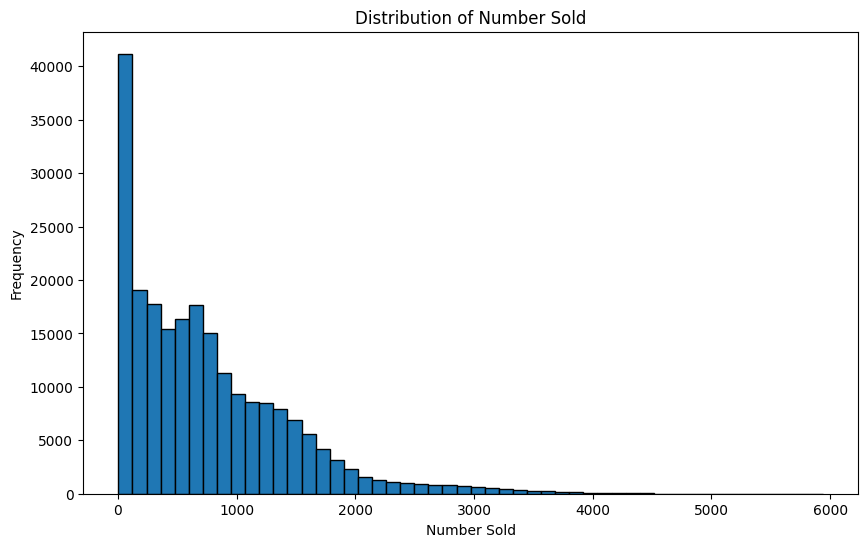

In [59]:
# Histogram of the target variable
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(train['num_sold'], bins=50, edgecolor='k')
plt.title("Distribution of Number Sold")
plt.xlabel("Number Sold")
plt.ylabel("Frequency")
plt.show()


In [60]:
# Count of missing values
missing_count = train['num_sold'].isnull().sum()
print(f"Number of missing values in num_sold: {missing_count}")

Number of missing values in num_sold: 8871


In [61]:
# Analyze the rows with missing values
missing_data = train[train['num_sold'].isnull()]
print("\nRows with missing num_sold:")
print(missing_data.head(10))


Rows with missing num_sold:
      id        date country              store            product  num_sold
0      0  2010-01-01  Canada  Discount Stickers  Holographic Goose       NaN
45    45  2010-01-01   Kenya  Discount Stickers  Holographic Goose       NaN
90    90  2010-01-02  Canada  Discount Stickers  Holographic Goose       NaN
135  135  2010-01-02   Kenya  Discount Stickers  Holographic Goose       NaN
180  180  2010-01-03  Canada  Discount Stickers  Holographic Goose       NaN
225  225  2010-01-03   Kenya  Discount Stickers  Holographic Goose       NaN
270  270  2010-01-04  Canada  Discount Stickers  Holographic Goose       NaN
315  315  2010-01-04   Kenya  Discount Stickers  Holographic Goose       NaN
320  320  2010-01-04   Kenya  Stickers for Less  Holographic Goose       NaN
360  360  2010-01-05  Canada  Discount Stickers  Holographic Goose       NaN


In [62]:
# Check how missing values are distributed across other features
print("\nDistribution of missing values across features:")
print(missing_data[['date', 'country', 'store', 'product']].describe())


Distribution of missing values across features:
              date country              store            product
count         8871    8871               8871               8871
unique        2557       2                  3                  3
top     2010-04-21   Kenya  Discount Stickers  Holographic Goose
freq             7    4625               5179               8806


In [63]:
"""
Option 1: Imputation

Fill the missing values with a reasonable estimate based on available data. Common methods:

    Mean/Median Imputation: Replace missing values with the average or median num_sold for similar groups (e.g., based on country, store, and product).
    Mode Imputation: For categorical variables, replace missing values with the most frequent category.
    Regression Imputation: Predict missing values using a regression model based on other features.

# Group by country, store, product and calculate mean num_sold
group_means = train.groupby(['country', 'store', 'product'])['num_sold'].transform('mean')

# Fill missing values with group means
train['num_sold'].fillna(group_means, inplace=True)

# Check if missing values are resolved
print("Missing values after imputation:", train['num_sold'].isnull().sum())

When to use:

    If missing values are randomly distributed.
    If there's enough historical data to compute meaningful averages.
"""

'\nOption 1: Imputation\n\nFill the missing values with a reasonable estimate based on available data. Common methods:\n\n    Mean/Median Imputation: Replace missing values with the average or median num_sold for similar groups (e.g., based on country, store, and product).\n    Mode Imputation: For categorical variables, replace missing values with the most frequent category.\n    Regression Imputation: Predict missing values using a regression model based on other features.\n\n# Group by country, store, product and calculate mean num_sold\ngroup_means = train.groupby([\'country\', \'store\', \'product\'])[\'num_sold\'].transform(\'mean\')\n\n# Fill missing values with group means\ntrain[\'num_sold\'].fillna(group_means, inplace=True)\n\n# Check if missing values are resolved\nprint("Missing values after imputation:", train[\'num_sold\'].isnull().sum())\n\nWhen to use:\n\n    If missing values are randomly distributed.\n    If there\'s enough historical data to compute meaningful avera

In [64]:
'''

Option 2: Interpolation
Estimate missing values based on surrounding dates (useful for time series data).



# Interpolate missing values for num_sold within each group
train['num_sold'] = train.groupby(['country', 'store', 'product'])['num_sold'].transform(lambda x: x.interpolate(method='linear'))


# Check if missing values are resolved
print("Missing values after interpolation:", train['num_sold'].isnull().sum())

When to use:

    If missing values occur in a continuous time range.
    If the data exhibits a clear trend or seasonality.

'''


'\n\nOption 2: Interpolation\nEstimate missing values based on surrounding dates (useful for time series data).\n\n\n\n# Interpolate missing values for num_sold within each group\ntrain[\'num_sold\'] = train.groupby([\'country\', \'store\', \'product\'])[\'num_sold\'].transform(lambda x: x.interpolate(method=\'linear\'))\n\n\n# Check if missing values are resolved\nprint("Missing values after interpolation:", train[\'num_sold\'].isnull().sum())\n\nWhen to use:\n\n    If missing values occur in a continuous time range.\n    If the data exhibits a clear trend or seasonality.\n\n'

In [65]:
'''

Option 3: Exclude Missing Values

If the percentage of missing values is small (<5-10%), you might drop the rows:

When to use:

    If you believe the missing data is random and not indicative of an underlying trend.
    When the amount of data is large and dropping rows won't significantly affect the training dataset.

'''

# Drop rows with missing values
train_cleaned = train.dropna(subset=['num_sold'])

# Verify
print("Rows remaining after dropping missing values:", len(train_cleaned))



Rows remaining after dropping missing values: 221259


In [66]:
# Verify the dataset size and check for remaining missing values
print(f"Original dataset size: {len(train)}")
print(f"Dataset size after dropping missing values: {len(train_cleaned)}")
print(f"Remaining missing values in num_sold: {train_cleaned['num_sold'].isnull().sum()}")

Original dataset size: 230130
Dataset size after dropping missing values: 221259
Remaining missing values in num_sold: 0


Exploratory Data Analysis

In [67]:
# Analyze trend over time
# Convert date column to datetime
train_cleaned['date'] = pd.to_datetime(train_cleaned['date'])

# Aggregate sales by date
daily_sales = train_cleaned.groupby('date')['num_sold'].sum().reset_index()

<ipython-input-67-43ec8bbc7072>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cleaned['date'] = pd.to_datetime(train_cleaned['date'])


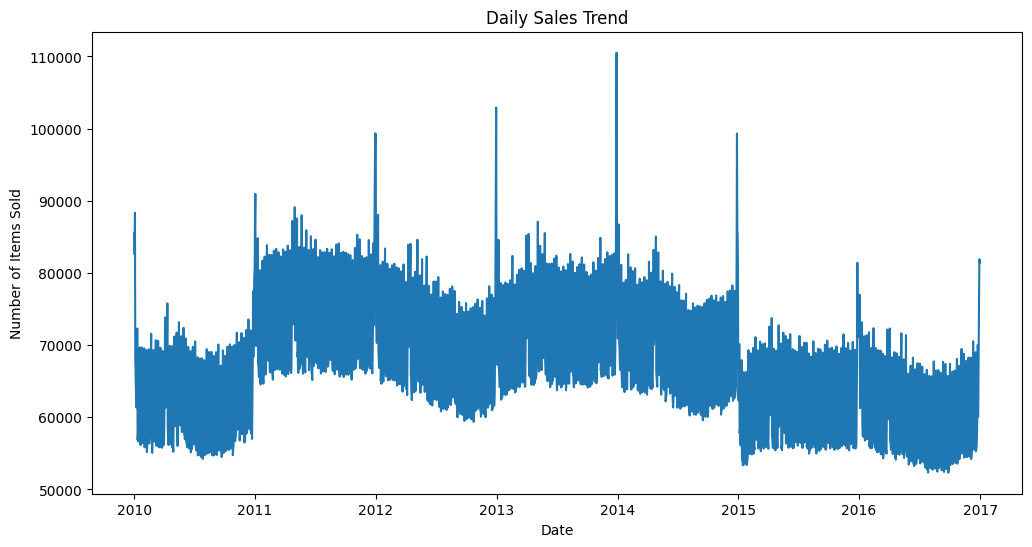

In [68]:
# Plot the daily sales trend

plt.figure(figsize=(12, 6))
plt.plot(daily_sales['date'], daily_sales['num_sold'])
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Number of Items Sold")
plt.show()

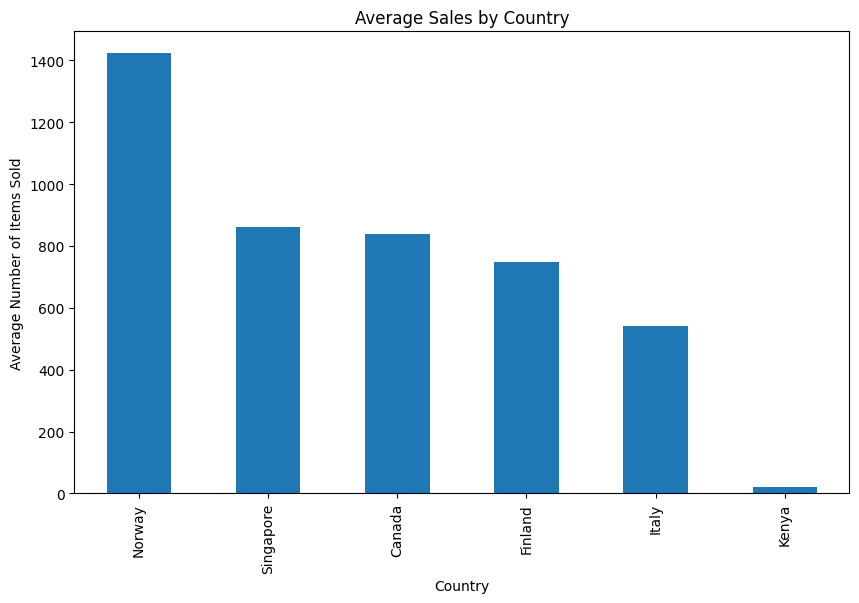

In [69]:
# Analyze Categorical Variables
# Average sales by country
avg_sales_country = train_cleaned.groupby('country')['num_sold'].mean().sort_values(ascending=False)

# Plot average sales by country
avg_sales_country.plot(kind='bar', figsize=(10, 6), title="Average Sales by Country")
plt.xlabel("Country")
plt.ylabel("Average Number of Items Sold")
plt.show()



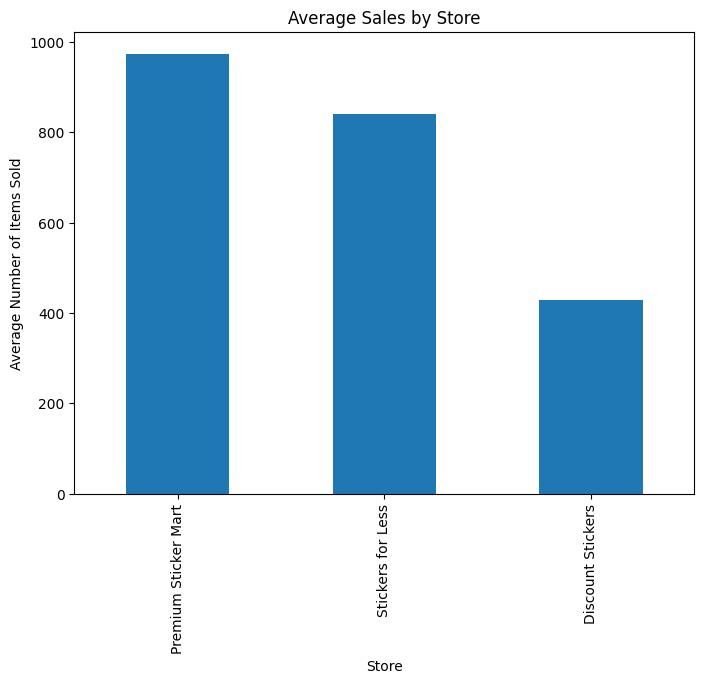

In [70]:
# Average sales by store
avg_sales_store = train_cleaned.groupby('store')['num_sold'].mean().sort_values(ascending=False)

# Plot average sales by store
avg_sales_store.plot(kind='bar', figsize=(8, 6), title="Average Sales by Store")
plt.xlabel("Store")
plt.ylabel("Average Number of Items Sold")
plt.show()



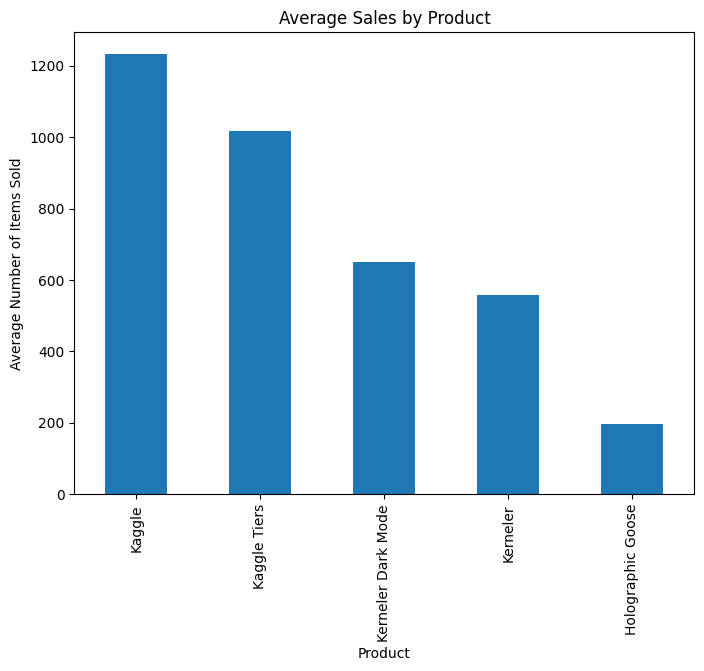

In [71]:
# Average sales by product
avg_sales_product = train_cleaned.groupby('product')['num_sold'].mean().sort_values(ascending=False)

# Plot average sales by product
avg_sales_product.plot(kind='bar', figsize=(8, 6), title="Average Sales by Product")
plt.xlabel("Product")
plt.ylabel("Average Number of Items Sold")
plt.show()


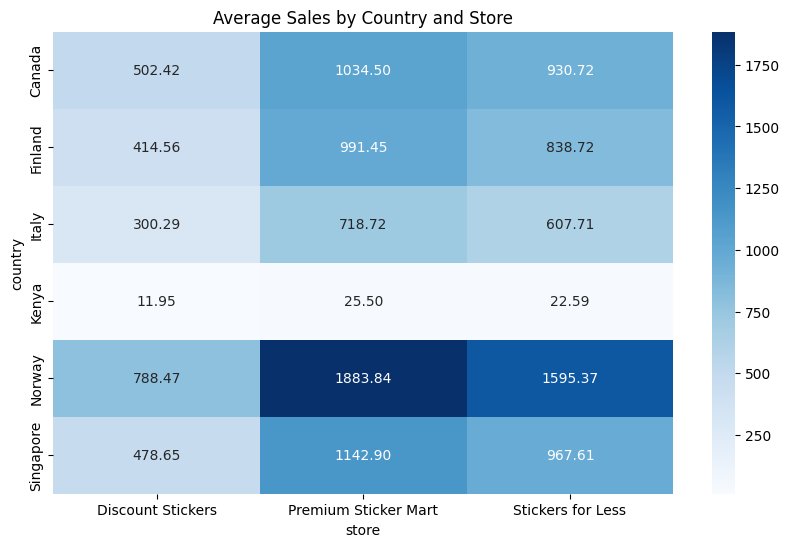

In [72]:
# Analyze Interactions
# Average sales by country and store
avg_sales_country_store = train_cleaned.groupby(['country', 'store'])['num_sold'].mean().unstack()

# Heatmap to visualize interactions

plt.figure(figsize=(10, 6))
sns.heatmap(avg_sales_country_store, annot=True, fmt=".2f", cmap="Blues")
plt.title("Average Sales by Country and Store")
plt.show()


In [73]:
# Count unique values for each categorical column
country_counts = train_cleaned['country'].value_counts()
store_counts = train_cleaned['store'].value_counts()
product_counts = train_cleaned['product'].value_counts()

# Display the counts
print("Count of countries:")
print(country_counts)

print("\nCount of stores:")
print(store_counts)

print("\nCount of products:")
print(product_counts)


Count of countries:
country
Finland      38355
Italy        38355
Norway       38355
Singapore    38355
Canada       34109
Kenya        33730
Name: count, dtype: int64

Count of stores:
store
Premium Sticker Mart    75684
Stickers for Less       74044
Discount Stickers       71531
Name: count, dtype: int64

Count of products:
product
Kaggle                46026
Kaggle Tiers          46026
Kerneler Dark Mode    46025
Kerneler              45962
Holographic Goose     37220
Name: count, dtype: int64


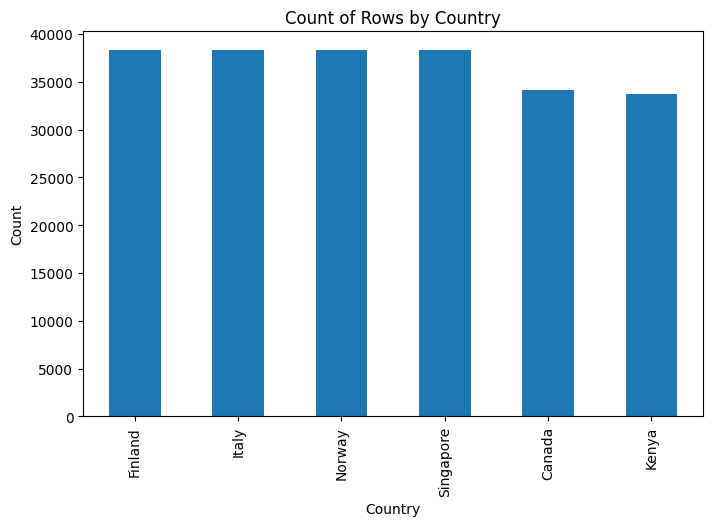

In [74]:
# Plot count of countries
plt.figure(figsize=(8, 5))
country_counts.plot(kind='bar')
plt.title("Count of Rows by Country")
plt.xlabel("Country")
plt.ylabel("Count")
plt.show()

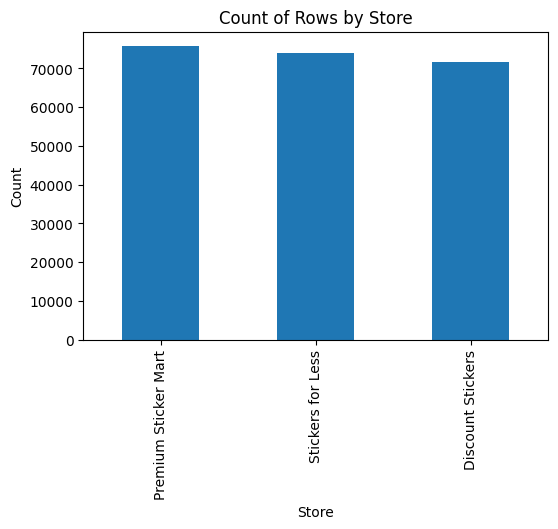

In [75]:
# Plot count of stores
plt.figure(figsize=(6, 4))
store_counts.plot(kind='bar')
plt.title("Count of Rows by Store")
plt.xlabel("Store")
plt.ylabel("Count")
plt.show()

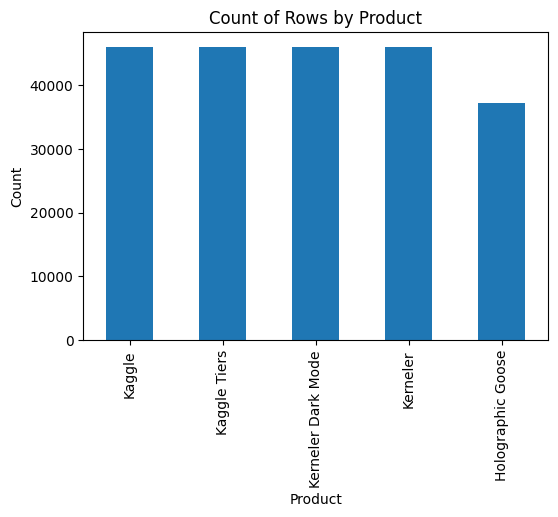

In [76]:
# Plot count of products
plt.figure(figsize=(6, 4))
product_counts.plot(kind='bar')
plt.title("Count of Rows by Product")
plt.xlabel("Product")
plt.ylabel("Count")
plt.show()


In [77]:
# Average sales by category
avg_sales_by_country = train_cleaned.groupby('country')['num_sold'].mean()
avg_sales_by_store = train_cleaned.groupby('store')['num_sold'].mean()
avg_sales_by_product = train_cleaned.groupby('product')['num_sold'].mean()

# Combine counts and average sales into a single DataFrame for each category
country_analysis = pd.DataFrame({
    'Count': country_counts,
    'Avg Sales': avg_sales_by_country
})

store_analysis = pd.DataFrame({
    'Count': store_counts,
    'Avg Sales': avg_sales_by_store
})

product_analysis = pd.DataFrame({
    'Count': product_counts,
    'Avg Sales': avg_sales_by_product
})

# Display the combined DataFrames
print("\nCountry Analysis:")
print(country_analysis)

print("\nStore Analysis:")
print(store_analysis)

print("\nProduct Analysis:")
print(product_analysis)



Country Analysis:
           Count  Avg Sales
country                    
Canada     34109     840.05
Finland    38355     748.24
Italy      38355     542.24
Kenya      33730      20.43
Norway     38355   1,422.56
Singapore  38355     863.05

Store Analysis:
                      Count  Avg Sales
store                                 
Discount Stickers     71531     427.78
Premium Sticker Mart  75684     973.84
Stickers for Less     74044     840.05

Product Analysis:
                    Count  Avg Sales
product                             
Holographic Goose   37220     197.48
Kaggle              46026   1,232.38
Kaggle Tiers        46026   1,018.34
Kerneler            45962     556.91
Kerneler Dark Mode  46025     651.04


Feature Engineering

In [78]:
# Extract new features from date column
train_cleaned['day_of_week'] = train_cleaned['date'].dt.dayofweek  # Monday=0, Sunday=6
train_cleaned['is_weekend'] = train_cleaned['day_of_week'] >= 5    # True for Saturday & Sunday
train_cleaned['month'] = train_cleaned['date'].dt.month
train_cleaned['year'] = train_cleaned['date'].dt.year
train_cleaned['day'] = train_cleaned['date'].dt.day



<ipython-input-78-24b5667b1b3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cleaned['day_of_week'] = train_cleaned['date'].dt.dayofweek  # Monday=0, Sunday=6
<ipython-input-78-24b5667b1b3a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cleaned['is_weekend'] = train_cleaned['day_of_week'] >= 5    # True for Saturday & Sunday
<ipython-input-78-24b5667b1b3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [79]:
#Creating Rolling Averages and Lag Features

# Sort data by date for consistent lag/rolling computations
train_cleaned.sort_values(['country', 'store', 'product', 'date'], inplace=True)

# Create lag features
train_cleaned['lag_1'] = train_cleaned.groupby(['country', 'store', 'product'])['num_sold'].shift(1)
train_cleaned['lag_7'] = train_cleaned.groupby(['country', 'store', 'product'])['num_sold'].shift(7)

# Create rolling average features
train_cleaned['rolling_mean_7'] = train_cleaned.groupby(['country', 'store', 'product'])['num_sold'].transform(lambda x: x.rolling(window=7).mean())
train_cleaned['rolling_sum_7'] = train_cleaned.groupby(['country', 'store', 'product'])['num_sold'].transform(lambda x: x.rolling(window=7).sum())

# Check the data
print(train_cleaned.head())


<ipython-input-79-db503f61a18f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cleaned.sort_values(['country', 'store', 'product', 'date'], inplace=True)
<ipython-input-79-db503f61a18f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cleaned['lag_1'] = train_cleaned.groupby(['country', 'store', 'product'])['num_sold'].shift(1)
<ipython-input-79-db503f61a18f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

      id       date country              store product  num_sold  day_of_week  \
1      1 2010-01-01  Canada  Discount Stickers  Kaggle    973.00            4   
91    91 2010-01-02  Canada  Discount Stickers  Kaggle    881.00            5   
181  181 2010-01-03  Canada  Discount Stickers  Kaggle  1,003.00            6   
271  271 2010-01-04  Canada  Discount Stickers  Kaggle    744.00            0   
361  361 2010-01-05  Canada  Discount Stickers  Kaggle    707.00            1   

     is_weekend  month  year  day    lag_1  lag_7  rolling_mean_7  \
1         False      1  2010    1      NaN    NaN             NaN   
91         True      1  2010    2   973.00    NaN             NaN   
181        True      1  2010    3   881.00    NaN             NaN   
271       False      1  2010    4 1,003.00    NaN             NaN   
361       False      1  2010    5   744.00    NaN             NaN   

     rolling_sum_7  
1              NaN  
91             NaN  
181            NaN  
271           

<ipython-input-79-db503f61a18f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cleaned['rolling_sum_7'] = train_cleaned.groupby(['country', 'store', 'product'])['num_sold'].transform(lambda x: x.rolling(window=7).sum())


Data Preparation for Modeling

In [80]:
# One-hot encoding
train_encoded = pd.get_dummies(train_cleaned, columns=['country', 'store', 'product'], drop_first=False)

# Check encoded columns
print("Columns after one-hot encoding:", train_encoded.columns)


Columns after one-hot encoding: Index(['id', 'date', 'num_sold', 'day_of_week', 'is_weekend', 'month', 'year',
       'day', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_sum_7',
       'country_Canada', 'country_Finland', 'country_Italy', 'country_Kenya',
       'country_Norway', 'country_Singapore', 'store_Discount Stickers',
       'store_Premium Sticker Mart', 'store_Stickers for Less',
       'product_Holographic Goose', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode'],
      dtype='object')


In [81]:
# Check the data
print(train_encoded.head())

      id       date  num_sold  day_of_week  is_weekend  month  year  day  \
1      1 2010-01-01    973.00            4       False      1  2010    1   
91    91 2010-01-02    881.00            5        True      1  2010    2   
181  181 2010-01-03  1,003.00            6        True      1  2010    3   
271  271 2010-01-04    744.00            0       False      1  2010    4   
361  361 2010-01-05    707.00            1       False      1  2010    5   

       lag_1  lag_7  rolling_mean_7  rolling_sum_7  country_Canada  \
1        NaN    NaN             NaN            NaN            True   
91    973.00    NaN             NaN            NaN            True   
181   881.00    NaN             NaN            NaN            True   
271 1,003.00    NaN             NaN            NaN            True   
361   744.00    NaN             NaN            NaN            True   

     country_Finland  country_Italy  country_Kenya  country_Norway  \
1              False          False          False  

In [82]:
# Split data into train and validation sets
train_set = train_encoded[train_encoded['date'] < '2016-01-01']  # Adjust date for your use case
valid_set = train_encoded[train_encoded['date'] >= '2016-01-01']

# Drop unnecessary columns (e.g., date and id) for modeling
X_train = train_set.drop(columns=['num_sold', 'date', 'id'])
y_train = train_set['num_sold']

X_valid = valid_set.drop(columns=['num_sold', 'date', 'id'])
y_valid = valid_set['num_sold']

# Verify the split
print(f"Training Set: {X_train.shape}, Validation Set: {X_valid.shape}")


Training Set: (189492, 23), Validation Set: (31767, 23)


Model Training

In [83]:
# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# Define model parameters
params = {
    'objective': 'regression',
    'metric': 'mape',  # Mean Absolute Percentage Error
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42
}

# Train the model
# Use the lgb.early_stopping() and lgb.log_evaluation() callbacks
model = lgb.train(params,
                train_data,
                valid_sets=[train_data, valid_data],
                num_boost_round=1000,
                callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True),
                           lgb.log_evaluation(50)], # Add lgb.log_evaluation() for verbose output
                )  # Remove verbose_eval

# Make predictions on the validation set
y_pred = model.predict(X_valid)

# Evaluate the model
mape_score = mean_absolute_percentage_error(y_valid, y_pred)
print(f"Validation MAPE: {mape_score:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 189492, number of used features: 23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 765.093951
Training until validation scores don't improve for 50 rounds
[50]	training's mape: 0.125429	valid_1's mape: 0.114624
[100]	training's mape: 0.0666918	valid_1's mape: 0.0624552
[150]	training's mape: 0.0625724	valid_1's mape: 0.0588124
[200]	training's mape: 0.0601068	valid_1's mape: 0.0571672
[250]	training's mape: 0.0586958	valid_1's mape: 0.0564609
[300]	training's mape: 0.0576373	valid_1's mape: 0.0556919
[350]	training's mape: 0.0567883	valid_1's mape: 0.055235
[400]	training's mape: 0.

In [84]:
import xgboost
print(xgboost.__version__)


2.1.3


In [85]:
!pip install --upgrade xgboost


In [86]:
import xgboost as xgb

# Convert data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Define parameters
params = {
    'objective': 'reg:squarederror',  # Regression objective
    'learning_rate': 0.1,
    'max_depth': 6,
    'seed': 42,
    'eval_metric': 'mae'  # Evaluation metric
}

# Train the model with early stopping
evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,  # Maximum number of boosting rounds
    evals=evals,
    early_stopping_rounds=50,  # Early stopping if no improvement
    verbose_eval=50
)

# Make predictions
y_pred_xgb = xgb_model.predict(dvalid)

# Evaluate MAPE
mape_xgb = mean_absolute_percentage_error(y_valid, y_pred_xgb)
print(f"XGBoost Validation MAPE: {mape_xgb:.4f}")


[0]	train-mae:487.43999	eval-mae:439.33060
[50]	train-mae:33.62265	eval-mae:30.00671
[100]	train-mae:31.75589	eval-mae:28.98418
[150]	train-mae:31.04725	eval-mae:28.83503
[200]	train-mae:30.50438	eval-mae:28.71647
[250]	train-mae:30.11065	eval-mae:28.65384
[300]	train-mae:29.75451	eval-mae:28.60721
[350]	train-mae:29.47678	eval-mae:28.57152
[400]	train-mae:29.19596	eval-mae:28.54555
[435]	train-mae:29.01617	eval-mae:28.53833
XGBoost Validation MAPE: 0.0526


In [87]:
#Train Prophet

prophet_data = train_cleaned.groupby('date')['num_sold'].sum().reset_index()
prophet_data.columns = ['ds', 'y']  # Prophet requires columns named 'ds' and 'y'


In [88]:
from prophet import Prophet

# Initialize Prophet
prophet_model = Prophet()

# Fit the model
prophet_model.fit(prophet_data)

# Make future predictions
future_dates = prophet_model.make_future_dataframe(periods=len(valid_set['date'].unique()))
forecast = prophet_model.predict(future_dates)

# Evaluate predictions on validation set
# 1. Merge forecast with valid_set to align predictions by date:
valid_set['date_str'] = valid_set['date'].astype(str)  # Convert date to string for merging
forecast['ds_str'] = forecast['ds'].astype(str)        # Convert ds to string for merging

merged_data = pd.merge(valid_set, forecast[['ds_str', 'yhat']],
                      left_on='date_str', right_on='ds_str', how='left')



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz4cl795e/h8zlew4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz4cl795e/nc2d2rvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97004', 'data', 'file=/tmp/tmpz4cl795e/h8zlew4d.json', 'init=/tmp/tmpz4cl795e/nc2d2rvi.json', 'output', 'file=/tmp/tmpz4cl795e/prophet_model4r7z02d3/prophet_model-20250131184103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-88-404314686ae7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [89]:
# 2. Now, you can compare y_valid and yhat which have the same length:
y_valid_prophet = merged_data['yhat'].values
mape_prophet = mean_absolute_percentage_error(y_valid, y_valid_prophet)
print(f"Prophet Validation MAPE: {mape_prophet:.4f}")

Prophet Validation MAPE: 729.1952


In [90]:
#Train Random Forest

from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_valid)
mape_rf = mean_absolute_percentage_error(y_valid, y_pred_rf)
print(f"Random Forest Validation MAPE: {mape_rf:.4f}")


Random Forest Validation MAPE: 0.0466


In [91]:
# Append test dataset to the training dataset (excluding num_sold)
test['num_sold'] = None  # Placeholder to align columns
full_data = pd.concat([train_cleaned, test], axis=0)

# Sort by date for consistency
full_data = full_data.sort_values(by=['country', 'store', 'product', 'date'])

# Create lag features using the full dataset
full_data['lag_1'] = full_data.groupby(['country', 'store', 'product'])['num_sold'].shift(1)
full_data['lag_7'] = full_data.groupby(['country', 'store', 'product'])['num_sold'].shift(7)
full_data['rolling_mean_7'] = full_data.groupby(['country', 'store', 'product'])['num_sold'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
full_data['rolling_sum_7'] = full_data.groupby(['country', 'store', 'product'])['num_sold'].transform(lambda x: x.rolling(window=7, min_periods=1).sum())

# Extract only the test rows
test = full_data[full_data['num_sold'].isnull()].drop(columns=['num_sold'])


<ipython-input-91-3912a60e9293>:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_data = pd.concat([train_cleaned, test], axis=0)


In [92]:
# One-hot encode categorical variables to match training
test_encoded = pd.get_dummies(test, columns=['country', 'store', 'product'], drop_first=True)

# Ensure test data has the same features as train
missing_cols = set(X_train.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0  # Add missing columns with default value 0

# Keep only the columns present in the training set
test_encoded = test_encoded[X_train.columns]

# Make predictions using the trained Random Forest model
test_predictions = rf_model.predict(test_encoded)

# Ensure no negative predictions
test_predictions = [max(0, pred) for pred in test_predictions]

# Create submission DataFrame
test['num_sold'] = test_predictions
submission = test[['id', 'num_sold']]

# Save to CSV
submission.to_csv('submission_random_forest.csv', index=False)

print("Submission file saved: submission_random_forest.csv")


Submission file saved: submission_random_forest.csv


In [93]:
from sklearn.metrics import mean_absolute_percentage_error

# Predict on validation set again
y_pred_rf_valid = rf_model.predict(X_valid)

# Compute MAPE for validation set
mape_rf_valid = mean_absolute_percentage_error(y_valid, y_pred_rf_valid)
print(f"Random Forest Validation MAPE: {mape_rf_valid:.4f}")


Random Forest Validation MAPE: 0.0466
